Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [7]:
# importing relevant libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential

from keras.layers import  Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import glob
import cv2

In [8]:
## mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/Melanoma/'
data_dir_train = pathlib.Path(root_path + "Train/")
# checking the path variable
print(data_dir_train)
data_dir_test = pathlib.Path(root_path + "Test/")

/content/gdrive/MyDrive/Melanoma/Train


In [10]:
# printing the count of images for both train and test data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [12]:
## creating train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## creating validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# Listing out all the classes of skin cancer and storing them in a list.  
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualizing one instance of all the nine classes present in the dataset

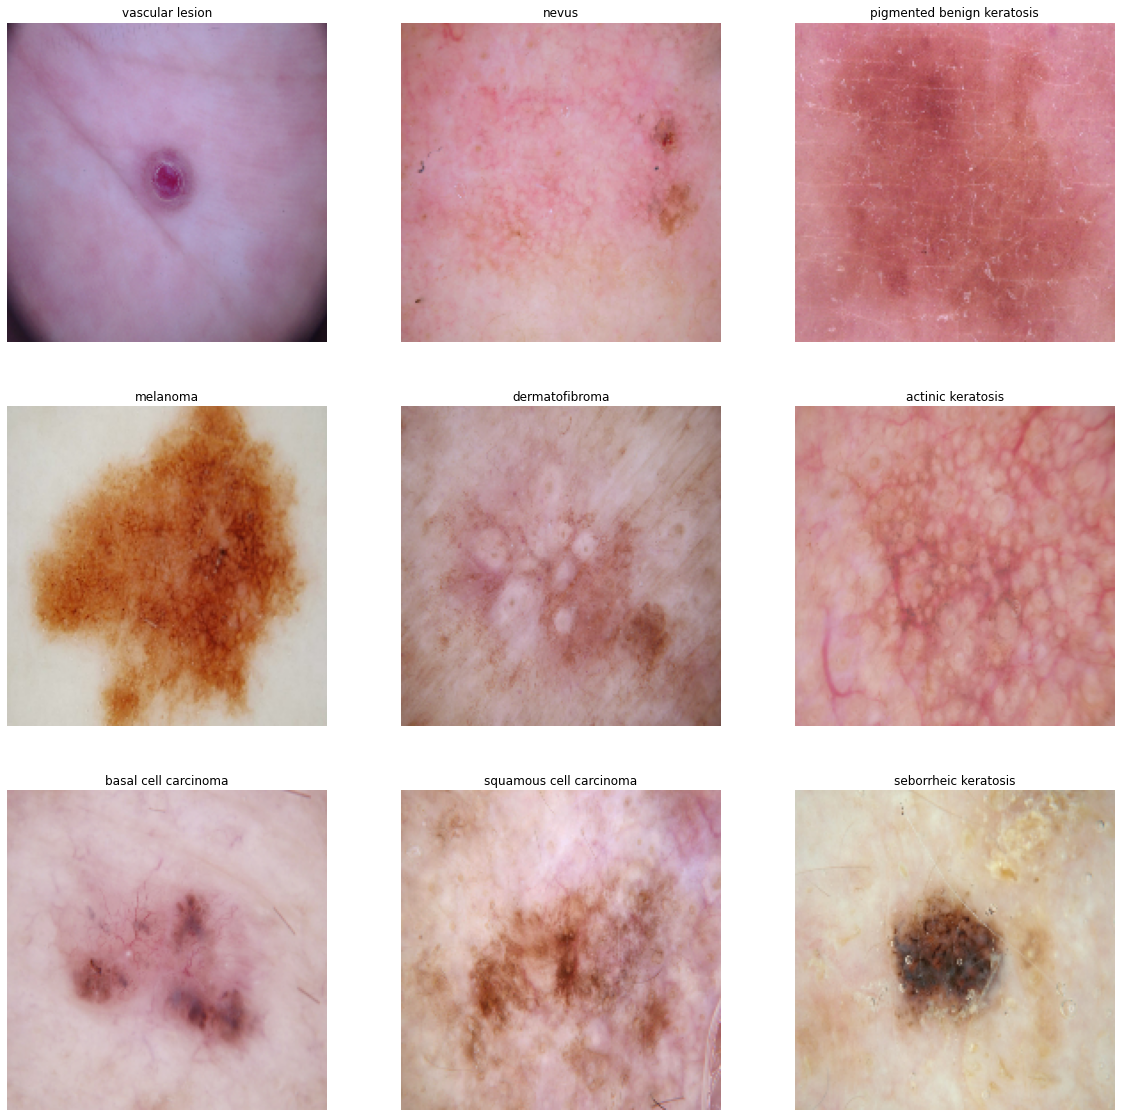

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
# takingconsidering training dataset
classes = train_ds.class_names
count=0
used_labels_list = []
# fetching images for each class
for images, labels in train_ds.take(3):
    for i in range(32):
        if (labels[i] not in used_labels_list):
            used_labels_list.append(labels[i])
            count += 1
            # plotting images 3 by 3
            ax = plt.subplot(3, 3, count)            
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(classes[labels[i]])
            plt.axis("off")
       


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Standardizing values in [0,1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
# Base model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(9))
model.add(Activation('softmax'))

### Using adam optimizer and categorical_crossentropy as loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 176, 176, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 88, 88, 64)        18496     
                                                        

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 204s 873ms/step - loss: 2.1642 - accuracy: 0.2165 - val_loss: 2.5405 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.8673 - accuracy: 0.3013 - val_loss: 1.6464 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 5s 87ms/step - loss: 1.5540 - accuracy: 0.4632 - val_loss: 1.5208 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 5s 87ms/step - loss: 1.4296 - accuracy: 0.4939 - val_loss: 1.4762 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 5s 88ms/step - loss: 1.3350 - accuracy: 0.5257 - val_loss: 1.6533 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 5s 88ms/step - loss: 1.2881 - accuracy: 0.5446 - val_loss: 1.6088 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 5s 88ms/step - loss: 1.1514 - accuracy: 0.5876 - val_loss: 1.7479 - val_accuracy: 0.4564
Epoch 8/20

### Visualizing training results

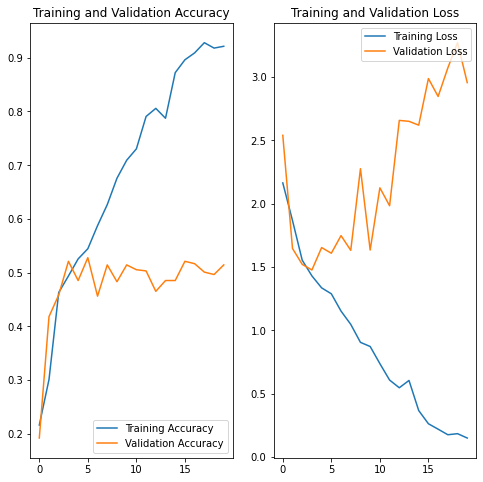

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### FINDINGS:-

- Clearly, the model is **OVERFITTING**. The training accuracy is increasing with each epoch (upto 92%) but validation accuracy is around 50% after 20 epochs.
- With each epoch the validation loss is increasing and training loss is decreasing.
- Overfitted model 

In [29]:
# Since the model is overfitting, we need to choose an appropriate data augumentation strategy. 
# Augmenting images by rotating, flipping, zooming, shearing, height-width shifting, and fill mode to be nearest 
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range            = 90.0,
    zoom_range                = [0.9,1.1],
    horizontal_flip           = [0.9,1.1],
    vertical_flip             = True,
    height_shift_range        = 10.0,
    width_shift_range         = 10.0,
    shear_range               = 5.0,
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',     
    validation_split          = 0.2                     
    )
                                  

# Generating batches of tensor image data for training subset with real-time augmentation
train_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='training',                  
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size,
                                                    class_mode='categorical',
                                                    )

# Generating batches of tensor image data for validation subset with real-time augmentation
val_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='validation',                 
                                                    target_size=(img_height, img_width),
                                                    batch_size = batch_size,
                                                    class_mode='categorical',
                                                    )

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


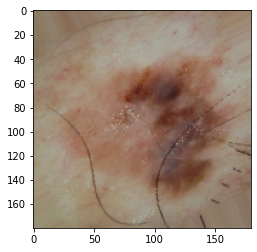

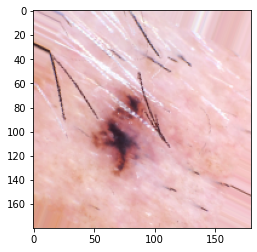

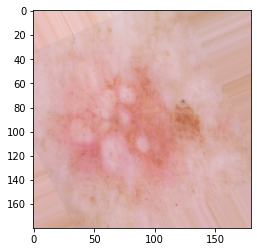

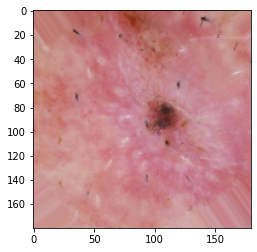

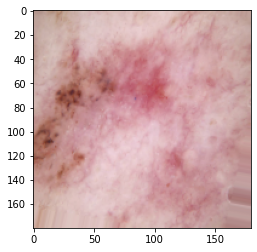

In [30]:
# Visualizing how augmentation strategy works for some training images
# Your code goes here
x_batch, y_batch = next(train_generator)

for i in range (0,5):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()   

### Create the model, compile and train the model


In [31]:
# Creating second model 
# Using Dropout layer to avoid overfitting
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
# using Dropout layer
model2.add(Dropout(0.15))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dense(128))
model2.add(Activation('relu'))
# using Dropout layer
model2.add(Dropout(0.15))
model2.add(Dense(9))
model2.add(Activation('softmax'))



### Compiling the model

In [32]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [33]:
epochs = 20
history_m2 = model2.fit(
  train_generator,
  validation_data=val_generator,
  epochs=epochs,
  workers=12
)

Epoch 1/20
57/57 [==============================] - 51s 798ms/step - loss: 2.0946 - accuracy: 0.1816 - val_loss: 2.0171 - val_accuracy: 0.1959
Epoch 2/20
57/57 [==============================] - 50s 769ms/step - loss: 2.0348 - accuracy: 0.1989 - val_loss: 2.0084 - val_accuracy: 0.1959
Epoch 3/20
57/57 [==============================] - 48s 758ms/step - loss: 1.9811 - accuracy: 0.2474 - val_loss: 1.9578 - val_accuracy: 0.2635
Epoch 4/20
57/57 [==============================] - 50s 778ms/step - loss: 1.7920 - accuracy: 0.3487 - val_loss: 1.7317 - val_accuracy: 0.3446
Epoch 5/20
57/57 [==============================] - 49s 764ms/step - loss: 1.6188 - accuracy: 0.4212 - val_loss: 1.5896 - val_accuracy: 0.4347
Epoch 6/20
57/57 [==============================] - 51s 781ms/step - loss: 1.5280 - accuracy: 0.4641 - val_loss: 2.2826 - val_accuracy: 0.4257
Epoch 7/20
57/57 [==============================] - 49s 752ms/step - loss: 1.5275 - accuracy: 0.4618 - val_loss: 1.7445 - val_accuracy: 0.4212

### Visualizing the results

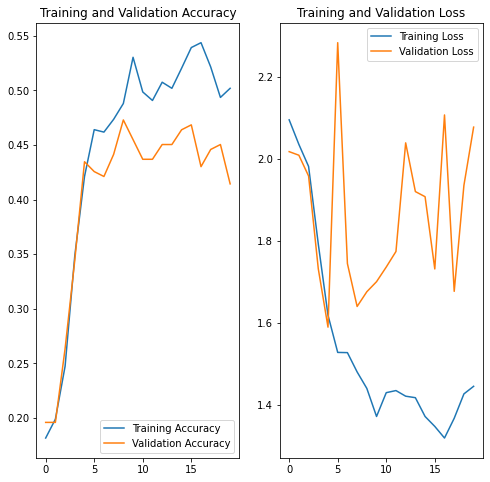

In [34]:
acc = history_m2.history['accuracy']
val_acc = history_m2.history['val_accuracy']

loss = history_m2.history['loss']
val_loss = history_m2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

FINDINGS:-
- Training and Validation accuracy are closely following each other. However, both are less than 50%
- Both the losses are less.
- This is a clear case of **UNDERFITTING**.
- By Augmentation, overfitting is handled

#### Checking distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Found 2239 files belonging to 9 classes.


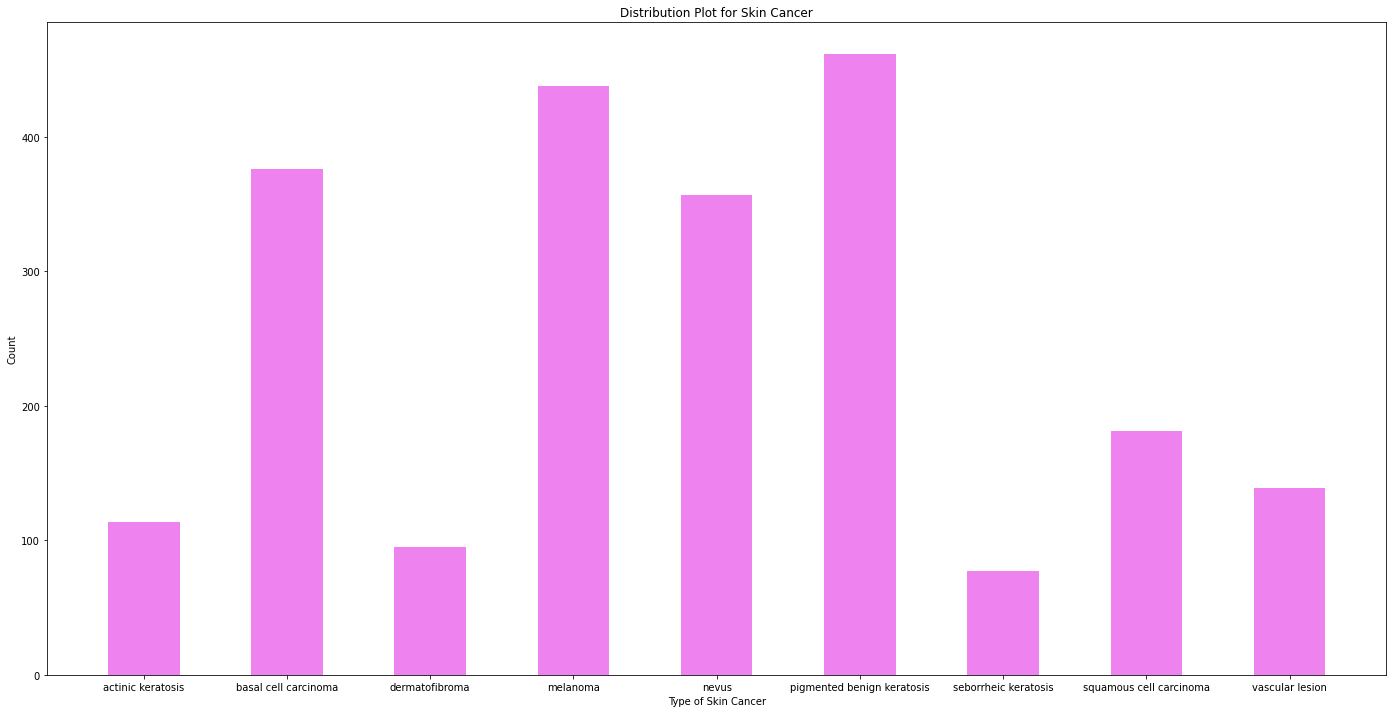

In [35]:
# reading the entire training dataset
train_ds_plot = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

train_ds_plot = train_ds_plot.map(lambda x, y: (normalization_layer(x), category_layer(y)))

# converting to numpy array
train_np = tfds.as_numpy(train_ds_plot)

distribution = []

# creating a dictionary obj to calculate the count of each skin cancer type
class_dist = dict()
for features_labels in train_np:
    for row in features_labels[1]:
        distribution.append(row)

dist_df = pd.DataFrame(distribution)   
dist_df.columns = class_names

# calculating count of eachtype
for cls in class_names:
    class_dist[cls] = dist_df[cls].sum()
    
keys = list(class_dist.keys())
values = list(class_dist.values())
  
# plotting distribution
fig = plt.figure(figsize = (24, 12)) 
plt.bar(keys, values, color ='violet', width = 0.5) 
plt.xlabel("Type of Skin Cancer")
plt.ylabel("Count")
plt.title("Distribution Plot for Skin Cancer")
plt.show()


## FINDINGS:-
#### - Which class has the least number of samples?
#### - Ans) seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
#### - Ans) pigmented benign keratosis


#### Need to Rectify the class imbalance
#### **Context:** We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset= root_path +'Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE2A2728ED0>: 100%|██████████| 500/500 [00:18<00:00, 27.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2A2728310>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE2A229B190>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE35C2155D0>: 100%|██████████| 500/500 [01:33<00:00,  5.35 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FE35C1D0C10>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE35FB34AD0>: 100%|██████████| 500/500 [00:18<00:00, 26.41 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE491FE3410>: 100%|██████████| 500/500 [00:41<00:00, 12.07 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2A2747F10>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE2A22792D0>: 100%|██████████| 500/500 [00:18<00:00, 26.59 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
# list of paths to the newly created augmented images directory
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


# list of paths of original images
path_list_original=[]
for cl in class_names:
    path_list = [x for x in glob.glob(os.path.join(data_dir_train,cl ,'*.jpg'))]
    path_list_original.extend(path_list)

In [40]:
# new lesion list
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(lesion_list_new))

# original lesion list
lesion_list_original = []
for cl in class_names:
    lesion_list_org= [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train,cl,'*.jpg'))]
    lesion_list_original.extend(lesion_list_org)
len(lesion_list_original)

4500


2239

In [41]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

In [42]:
# creating the new dataframe of all images
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
len(new_df)

6739

In [43]:
# count of each class
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating training dataset

In [45]:
path_to_training_dataset= root_path +'Train/'
data_dir_train= path_to_training_dataset

# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [46]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating final model (included normalization)

In [47]:
# normalization
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))

In [48]:
# creating 3rd model
model3 = Sequential( 
    [tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)])

model3.add(Conv2D(16, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(32, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(64, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.20))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dense(9))
model3.add(Activation('softmax'))

#### Compiling model

In [49]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Training model

In [50]:
epochs = 30

history_m3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  workers=12
  )# your model fit code

Epoch 1/30
169/169 [==============================] - 32s 174ms/step - loss: 1.8619 - accuracy: 0.2897 - val_loss: 1.5885 - val_accuracy: 0.3912
Epoch 2/30
169/169 [==============================] - 31s 175ms/step - loss: 1.5068 - accuracy: 0.4241 - val_loss: 1.4166 - val_accuracy: 0.4655
Epoch 3/30
169/169 [==============================] - 35s 201ms/step - loss: 1.4050 - accuracy: 0.4714 - val_loss: 1.4360 - val_accuracy: 0.4484
Epoch 4/30
169/169 [==============================] - 36s 207ms/step - loss: 1.3591 - accuracy: 0.4855 - val_loss: 1.4531 - val_accuracy: 0.4855
Epoch 5/30
169/169 [==============================] - 30s 173ms/step - loss: 1.2806 - accuracy: 0.5132 - val_loss: 1.4326 - val_accuracy: 0.4996
Epoch 6/30
169/169 [==============================] - 31s 176ms/step - loss: 1.2094 - accuracy: 0.5382 - val_loss: 1.1456 - val_accuracy: 0.5909
Epoch 7/30
169/169 [==============================] - 31s 176ms/step - loss: 1.1402 - accuracy: 0.5708 - val_loss: 1.1399 - val_ac

#### Visualizing the model results

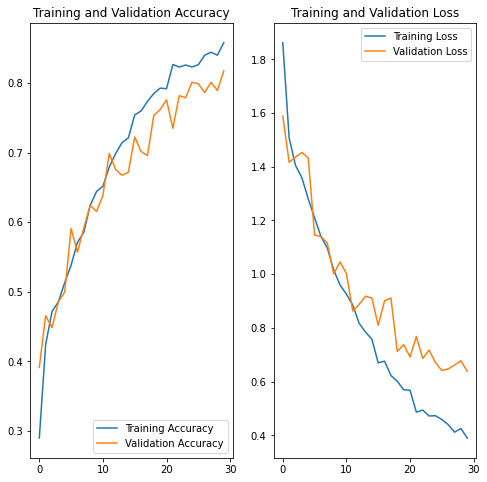

In [51]:
acc = history_m3.history['accuracy']
val_acc = history_m3.history['val_accuracy']

loss = history_m3.history['loss']
val_loss = history_m3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### FINDINGS:-
- The above model gives around 86% training accuracy and 82% validation accuracy after 30 epochs
- The graph suggests that model is a good fit and both overfitting and underfitting are handled
- Also, rebalancing the class imbalance using Augmentor library helped to fix both overfitting and underfitting



**TEST PREDICTION** : Lets use model 3 to do prediction on Test images

In [52]:
# test dataset
test_ds_org = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size  ,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 118 files belonging to 9 classes.


In [53]:
# normalization and one hot encoding
test_ds = test_ds_org.map(lambda x, y: (normalization_layer(x), category_layer(y)))


In [59]:
# doing prediction
y_pred = model3.predict(test_ds)

In [60]:
# extracting true labels 
test_np = tfds.as_numpy(test_ds_org)
y_true=[]

for features_labels in test_np:
    for row in features_labels[1]:
        y_true.append(row)

len(y_true)

118

In [61]:
# creating a dataframe for probability of each class and the true label
pred_df = pd.DataFrame(y_pred)
pred_df["true_value"] = y_true
pred_df.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 'true_value'], dtype='object')

In [62]:
# get prediction value as max probability class 
def get_pred(row):
  row = row.tolist()
  max_value = -1
  index = -1
  for i in range(0,9):
    if row[i] > max_value:
      max_value = row[i]
      index = i
  if row[9]==index:
    return True
  else: 
    return False


In [64]:
# predicted dataframe
pred_df["pred_value"] = pred_df.apply(lambda row: get_pred(row), axis = 1)
pred_df.head()


,0,1,2,3,4,5,6,7,8,true_value,pred_value
0,1.650642e-11,1.542482e-10,3.513024e-13,0.040595,0.955553,0.003850,2.099791e-06,5.709427e-13,7.000798e-31,1,False
1,4.424977e-01,1.870825e-01,1.424470e-06,0.000016,0.005005,0.328873,3.188531e-07,3.652212e-02,1.577310e-06,0,True
2,6.341220e-06,1.419877e-04,3.676880e-03,0.003056,0.001154,0.991915,2.673037e-07,4.892764e-05,1.567638e-14,2,False
3,6.175468e-01,6.314103e-03,6.599832e-07,0.000008,0.369815,0.005605,8.695949e-07,6.437507e-04,6.662527e-05,3,False
4,3.531058e-03,5.591155e-01,4.206622e-01,0.000082,0.001627,0.000568,1.119542e-05,1.439464e-02,8.590699e-06,0,False
